
# The Iris Dataset
This data sets consists of 3 different types of irises'
(Setosa, Versicolour, and Virginica) petal and sepal
length, stored in a 150x4 numpy.ndarray

The rows being the samples and the columns being:
Sepal Length, Sepal Width, Petal Length and Petal Width.

The below plot uses the first two features.
See [here](https://en.wikipedia.org/wiki/Iris_flower_data_set) for more
information on this dataset.


## Loading the iris dataset



In [112]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit,transpile, AncillaRegister,AncillaRegister, QuantumRegister, ClassicalRegister, assemble
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
import copy
iris = datasets.load_iris()
X=iris.data[0:100]
Y=iris.target[0:100]
X_train, X_test, Y_train, Y_test=model_selection.train_test_split(X,Y,test_size=0.33,random_state=42)

In [92]:
print(Y_train)

[0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1
 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1]


In [93]:
print(X_train[0])

[5.2 3.4 1.4 0.2]


In [94]:
N=4

In [96]:
def feature_map(X):
    q=QuantumRegister(N)
    c=ClassicalRegister(1)
    qc=QuantumCircuit(q,c)
    #qc.draw("mpl")
    for i, x in enumerate(X):
        qc.rx(x,i)
    return qc, c    

In [97]:
def variational_circuit(qc,theta):
    for i in range(N-1):
        qc.cx(i,i+1)
    qc.cx(N-1,0)
    for i in range(N):
        qc.ry(theta[i],i)
    return qc        

In [98]:
def quantum_nn(X,theta,simulator=True):
    qc,c=feature_map(X_train[0])
    qc.barrier()
    qc=variational_circuit(qc,theta)
    qc.barrier()
    qc.measure(0,c) 
 
    simulator = AerSimulator()
    circ = transpile(qc, simulator)
    shots=1E4
# Run and get counts
    #result = simulator.run(circ,shots, memory=True).result()
    result = simulator.run(circ).result()
    counts = result.get_counts(circ) 
    #print(counts)
    #print(counts['1'])
    
    return counts['1']/shots 

In [99]:
def loss(prediction,target):
    return (prediction-target)

In [101]:
prediction=quantum_nn(X_train[6],np.random.rand(N))
target=Y_train[6]
loss(prediction,target)
#qc.draw('mpl')

0.0586

In [107]:
def gradient(X,Y,theta):
    delta=0.01
    grad=[]
    for i in range(len(theta)):
        dtheta=copy.copy(theta)
        dtheta[i]+=delta
        pred1=quantum_nn(X,dtheta)
        pred2=quantum_nn(X,theta)
        grad.append((loss(pred1,Y)-loss(pred2,Y))/delta)
    
    return np.array(grad)


In [108]:
def accuracy(X,Y,theta):
    counter=0
    for X_i,Y_i in zip(X,Y):
        prediction=quantum_nn(X_i,theta)
        if prediction<0.5 and Y_i==0:
            counter+=1
        elif prediction>=0.5 and Y_i==1:
            counter+=1

    return counter/len(Y)        
    


In [118]:
eta=0.05
loss_list=[]
theta=np.ones(N)
print('Epoch \t Loss \t Training Accuracy')
for i in range(10):
    loss_tmp=[]
    for X_i,Y_i in zip(X_train,Y_train):
        prediction=quantum_nn(X_i,theta)
        loss_tmp.append(loss(prediction,Y_i))
        theta=theta-eta*gradient(X_i,Y_i,theta)
    loss_list.append(np.mean(loss_tmp))
    acc=accuracy(X_train,Y_train,theta)

    print(f'{i}\t {loss_list[-1]:.3f} \t {acc:.3f}')


Epoch 	 Loss 	 Training Accuracy
0	 -0.481 	 0.463
1	 -0.481 	 0.463
2	 -0.481 	 0.463
3	 -0.480 	 0.463
4	 -0.481 	 0.463
5	 -0.481 	 0.463
6	 -0.481 	 0.463
7	 -0.481 	 0.463
8	 -0.481 	 0.463
9	 -0.480 	 0.463


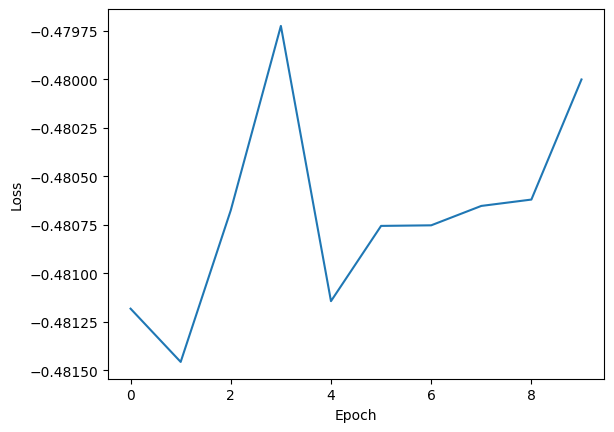

In [119]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()